# Skin cancer classification challenge

**Summary :** Skin cancer classification

## Preliminaries and Imports

In [1]:
import json
import collections
from PIL import Image
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

## I. Load metadata

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [2]:
#Set all paths for data
main_path = "ISIC-images/"
resized_folder = "data/resized"
folders = os.listdir(main_path)
#create a target forlder for resized pictures
if not os.path.exists(resized_folder):
    os.makedirs(resized_folder)

In [3]:
folders.remove('.DS_Store')

In [4]:
%%time
temp = []
for folder in folders:
    files = os.listdir(main_path+"/"+folder)
    for element in files :
        if ".json" in element:
            with open(main_path+"/"+folder+"/"+element) as json_data:
                d = json.load(json_data)
                d["folder"]=folder
            temp.append(d)

CPU times: user 887 ms, sys: 906 ms, total: 1.79 s
Wall time: 5.72 s


In [5]:
def flatten_dic(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten_dic(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [6]:
%%time
#flatten the meta key:
temp_ = [flatten_dic(d) for d in temp]

CPU times: user 705 ms, sys: 23.1 ms, total: 728 ms
Wall time: 1.04 s


In [7]:
#format as dataframe
meta = pd.DataFrame(temp_)
meta.head()

,_id,folder,meta_acquisition_dermoscopic_type,meta_acquisition_image_type,meta_acquisition_pixelsX,meta_acquisition_pixelsY,meta_clinical_age_approx,meta_clinical_benign_malignant,meta_clinical_clin_size_long_diam_mm,meta_clinical_diagnosis,meta_clinical_diagnosis_confirm_type,meta_clinical_family_hx_mm,meta_clinical_melanocytic,meta_clinical_personal_hx_mm,meta_clinical_sex,name
0,589de219d83113657d7b15f1,ISIC_MSK-4_1,contact non-polarized,dermoscopic,4288,2848,60.0,benign,NaN,nevus,histopathology,NaN,True,NaN,male,ISIC_0016008
1,581cd9309fc3c13dcd0e3a83,ISIC_MSK-4_1,contact non-polarized,dermoscopic,3008,2000,60.0,benign,NaN,nevus,histopathology,NaN,True,NaN,female,ISIC_0013965
2,581cd60d9fc3c13dcd0e0a1b,ISIC_MSK-4_1,contact non-polarized,dermoscopic,3008,2000,50.0,benign,NaN,nevus,histopathology,NaN,True,NaN,male,ISIC_0012677
3,581cd6e89fc3c13dcd0e1987,ISIC_MSK-4_1,contact non-polarized,dermoscopic,3872,2592,40.0,benign,NaN,seborrheic keratosis,histopathology,NaN,False,NaN,female,ISIC_0013089
4,581cd8269fc3c13dcd0e2bb7,ISIC_MSK-4_1,contact non-polarized,dermoscopic,3872,2592,60.0,malignant,NaN,melanoma,histopathology,NaN,True,NaN,male,ISIC_0013573


In [8]:
#saving file:
meta.to_csv("data/metadata.csv",index=False)

- **Data integrity check**

In [9]:
#data integrity check
#variable types
def summaryze(df):
    summary =  pd.DataFrame()
    summary["column"] = list(df.columns)
    summary["type"] = list(df.dtypes)
    summary["nb_missing_values"] = list(df.isnull().sum())
    summary["nb_missing_values%"] = summary["nb_missing_values"]/len(df)*100
    summary.set_index("column",inplace=True)
    return summary

In [10]:
summaryze(meta)

,type,nb_missing_values,nb_missing_values%
column,,,
_id,object,0,0.000000
folder,object,0,0.000000
meta_acquisition_dermoscopic_type,object,11669,84.643842
meta_acquisition_image_type,object,0,0.000000
meta_acquisition_pixelsX,int64,0,0.000000
meta_acquisition_pixelsY,int64,0,0.000000
meta_clinical_age_approx,float64,352,2.553315
meta_clinical_benign_malignant,object,15,0.108806
meta_clinical_clin_size_long_diam_mm,float64,12251,88.865516


> ** First interpretations : **
- Image datas are stored in band_1 and band_2 as matrix
- Training set contains only 1 604 rows... warning! Data augmentation and other tricks are to be considered.
- Inc_angle nature (?)

# II. Treat and resize pictures

In [13]:
#purge target folder
target  = "data/resized/"
filelist = [ f for f in os.listdir(target) if f.endswith(".jpg") ]
for f in filelist:
    os.remove(os.path.join(target, f))

In [12]:
def pad_center(img):
    longer_side = max(img.size)
    horizontal_padding = (longer_side - img.size[0]) / 2
    vertical_padding = (longer_side - img.size[1]) / 2
    img = img.crop(
        (
            -horizontal_padding,
            -vertical_padding,
            img.size[0] + horizontal_padding,
            img.size[1] + vertical_padding
        )
    )
    return img

In [14]:
def resize(source,target,size):
    dirs = os.listdir(source)
    dirs = [x for x in dirs if ".jpg" in x]
    for item in dirs:
        #print(source+"/"+item)
        im = Image.open(source+"/"+item)
        #f, e = os.path.splitext(source+"/"+item)
        im = pad_center(im)
        imResize = im.resize((size,size), Image.ANTIALIAS)
        imResize.save(target+item, 'JPEG', quality=100)
    return



In [15]:
%%time
image_size = 299
for folder in folders:
    resize(main_path+folder,"data/resized/",299)

CPU times: user 1h 38min 14s, sys: 5min 22s, total: 1h 43min 37s
Wall time: 2h 12min 31s


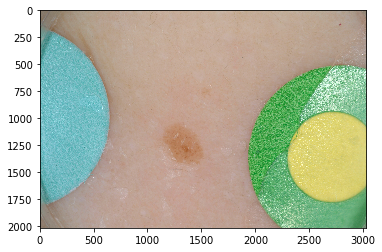

In [16]:
#resized pictures
temp = os.listdir(main_path+folder)
temp = [x for x in temp if ".jpg" in x]
img = Image.open(main_path+folder+"/"+temp[4])
plt.imshow(img)


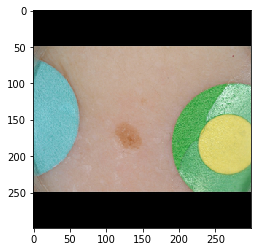

In [17]:
temp = os.listdir(main_path+folder)
temp = [x for x in temp if ".jpg" in x]
img = Image.open("data/resized/"+temp[4])
plt.imshow(img)    

**Warning : ** resizing pictures deform images? except if padding

In [18]:
#control
target  = "data/resized/"
filelist = [ f for f in os.listdir(target) if f.endswith(".jpg") ]

len(meta) == len(filelist)

True

In [19]:
print(len(meta))
print(len(filelist))

13786
13786


# III. Split into train and test